## 프로젝트 목표
---
1. 챗봇 훈련데이터 전처리 과정이 체계적으로 진행되었는가?
    * 챗봇 훈련데이터를 위한 전처리와 augmentation이 적절히 수행되어 3만개 가량의 훈련데이터셋이 구축되었다.
2. transformer 모델을 활용한 챗봇 모델이 과적합을 피해 안정적으로 훈련되었는가?
    * 과적합을 피할 수 있는 하이퍼파라미터 셋이 적절히 제시되었다.
3. 챗봇이 사용자의 질문에 그럴듯한 형태로 답하는 사례가 있는가?
    * 주어진 예문을 포함하여 챗봇에 던진 질문에 적절히 답하는 사례가 제출되었다.

### 라이브러리 확인
---
* models.py을 이용해 transformer class 구현
* utils.py을 이용해 데이터 전처리에 필요한 함수 및 기타 함수 구현

In [68]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import sentencepiece as spm
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

import re
import os
import random
import math
import gensim
import pickle

from tqdm.notebook import tqdm
from collections import Counter
import matplotlib.pyplot as plt

from utils import *
from models import Transformer, Encoder, Decoder

In [69]:
# GPU가 사용 가능한 경우, 기본 디바이스를 GPU로 설정
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')  # 첫 번째 GPU만 사용
        tf.config.experimental.set_memory_growth(gpus[0], True)  # 필요할 때만 GPU 메모리 사용
    except RuntimeError as e:
        print(e)

print("✅ GPU 활성화됨:", tf.config.list_physical_devices('GPU'))

✅ GPU 활성화됨: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 데이터 처리

### 데이터 다운로드
---
1. ChatbotData .csv
2. csv 파일을 읽는 데에는 pandas 라이브러리
3. 읽어 온 데이터의 질문과 답변을 각각 questions, answers 변수에 나눠서 저장


In [70]:
file_path = os.getenv('HOME') + "/aiffel/transformer_chatbot/data/"
df = pd.read_csv(file_path+"ChatbotData.csv")

In [71]:
df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [72]:
df.isnull().sum()

Q        0
A        0
label    0
dtype: int64

In [73]:
df = df.drop(columns=['label']) # 'label' 열 제거
df = df.drop_duplicates() # 중복 데이터 제거

In [74]:
print('the number of chatbot data: ', len(df))

the number of chatbot data:  11750


In [75]:
# train / test split 전에 무작위 shuffle
df = df.sample(frac=1).reset_index(drop=True) 
df.head()

,Q,A
0,커피 볶는 시간,커피향 좋겠어요.
1,뭐 해주기가 싫어,상처받았나봐요.
2,눈물만.,지금은 우세요.
3,내 주제를 모르고 덤빈건가,그건 아닐 거예요.
4,중2병,힘들 때네요.


### 데이터 정제
---
**utils.py** 파일에 아래 두 조건으로 **preprocess_sentence 함수 구현**

1. 영문자의 경우, ***모두 소문자로 변환***합니다.
2. 영문자와 한글, 숫자, 그리고 주요 특수문자를 제외하곤 ***정규식을 활용***하여 모두 ***제거***합니다.

### 데이터 토큰화
---
**utils.py** 파일에 아래 두 조건으로 **build_corpus 함수 구현**

1. ***소스 문장 데이터***와 ***타겟 문장 데이터***를 입력으로 받습니다.
2. 데이터를 앞서 정의한 ***preprocess_sentence() 함수로 정제하고, 토큰화***합니다.
3. 토큰화는 ***전달받은 토크나이즈 함수***를 사용합니다. 이번엔 ***mecab.morphs 함수***를 전달하시면 됩니다.
4. 토큰의 개수가 일정 길이 이상인 문장은 데이터에서 제외합니다.
5. ***중복되는 문장은 데이터에서 제외***합니다. 소스 : 타겟 쌍을 비교하지 않고 소스는 소스대로 타겟은 타겟대로 검사합니다. 중복 쌍이 흐트러지지 않도록 유의하세요!

In [76]:
# train / test split
test_len = len(df) // 10

que_corpus_train = df["Q"][:-test_len]
que_corpus_test = df["Q"][-test_len:]

ans_corpus_train = df["A"][:-test_len]
ans_corpus_test = df["A"][-test_len:]

In [77]:
que_corpus_train = build_corpus(que_corpus_train)
que_corpus_test = build_corpus(que_corpus_test, is_train=False) # test data에는 전처리만 진행

ans_corpus_train = build_corpus(ans_corpus_train)
ans_corpus_test = build_corpus(ans_corpus_test, is_train=False)

print(len(que_corpus_train))
print(len(ans_corpus_train))
print(len(que_corpus_test))
print(len(ans_corpus_test))

10575
10575
1175
1175


In [78]:
# 문장 길이 분석하기
print("최대 질문 문장 길이 : ", max(len(x) for x in que_corpus_train))
print("최소 질문 문장 길이 : ", min(len(x) for x in que_corpus_train))
print("평균 질문 문장 길이 : ", sum(map(len, que_corpus_train))/len(que_corpus_train))

최대 질문 문장 길이 :  32
최소 질문 문장 길이 :  1
평균 질문 문장 길이 :  7.033286052009457


In [79]:
print("최대 대답 문장 길이 : ", max(len(x) for x in ans_corpus_train))
print("최소 질문 문장 길이 : ", min(len(x) for x in ans_corpus_train))
print("평균 대답 문장 길이 : ", sum(map(len, ans_corpus_train))/len(ans_corpus_train))

최대 대답 문장 길이 :  40
최소 질문 문장 길이 :  1
평균 대답 문장 길이 :  8.382978723404255


### Augmentation
---
***Lexical Substitution을 실제로 적용***

In [80]:
from gensim.models import Word2Vec

file_path = os.getenv('HOME') + "/aiffel/transformer_chatbot/data/"
# Word2Vec 모델 로드
ko_vec = Word2Vec.load(file_path + 'word2vec_ko.model')

# 모델 테스트: 특정 단어의 벡터 확인
word_vector = ko_vec.wv["단어"]  # "단어"의 벡터
print(word_vector)


[-0.84295124 -0.59497476 -0.06958017  0.22912623 -1.6996183   2.8055239
  0.3761203  -2.6914809  -3.5348327  -1.8608217   0.18685858  0.08781391
 -1.5988438  -0.50004035  1.5011966   2.3389707  -2.1298397   2.3418503
  4.9678206  -2.016749   -1.60092    -1.0502566   0.6944076   1.3268162
  4.023851   -0.54679507  1.8050268  -0.34493855  0.15280624 -4.112347
 -0.7641386   0.8001268  -5.7092285   2.3291602   2.6685705   1.2506164
 -0.9265311  -1.4639043   1.0062082   0.95739704  2.1613991  -5.3201756
  4.1486487   0.7119045  -0.44255644  1.9117382   2.0401163   1.2536596
 -3.4907508   2.5135577   0.0192101   0.13117276  1.9888952   0.61847246
 -2.254515   -1.8180193  -0.01343717 -1.0221493   2.9350507  -2.5792298
  2.09504     2.306522    0.82577235 -3.3861275  -2.3184435  -2.7063618
 -0.20487231  0.6776788  -2.3545253  -1.3137537  -3.0127792  -0.6701537
 -2.089253    1.3784735  -4.1710854  -3.7226741   3.1941407  -3.574488
  0.3274521  -3.5230722  -2.13166     4.005327    0.7389973   0.

In [81]:
def lexical_sub(src, wv, ratio=0.5):
    result = []
    for tok in src:
        # 확률적으로 단어를 바꿀지 말지를 결정
        if tok in wv and random.random() < ratio:
            similar_words = wv.most_similar(tok, topn=1)  # 단어를 입력으로 사용
            result.append(similar_words[0][0] if similar_words else tok)
        else:
            result.append(tok)

    return result

In [82]:
src = '산은 산이고 물은 물이다 .'

print(" ".join(lexical_sub(src, ko_vec.wv, ratio=0.3)))

산기슭 은   산기슭 이 고   물 은   바닷물 이 다   .


In [17]:
aug_que_corpus_train = []

for old_src in que_corpus_train:
    new_src = lexical_sub(old_src, ko_vec.wv, ratio=0.3)
    aug_que_corpus_train.append(new_src)

In [38]:
# pickle로 저장
f_aug_que_corpus_train = open("aug_que_corpus_train.pickle","wb")
pickle.dump(aug_que_corpus_train,f_aug_que_corpus_train)
f_aug_que_corpus_train.close()


In [83]:
# pickle로 로딩
f_aug_que_corpus_train = open("aug_que_corpus_train.pickle","rb")
aug_que_corpus_train = pickle.load(f_aug_que_corpus_train)
f_aug_que_corpus_train.close()

In [84]:
print([" ".join(sample) for sample in que_corpus_train[:108]])
print([" ".join(sample) for sample in aug_que_corpus_train[:108]])

['커피 볶 는 시간', '뭐 해 주 기 가 싫 어', '눈물 만 .', '내 주제 를 모르 고 덤빈 건가', '중 2 병', '상황 이 어찌 됐 던 간 에 내 가 못 잊 겠 으면 연락 을 했 겠 죠 .', '보 고 싶 다고 하 네', '결국 연락 했 어', '남자 가 여자 를 좋아할 때 하 는 행동 이 뭐 가 있 나요 ?', '다 들 어떠셨 어 ? 결국 이렇게 되 는 건가', '일찍 퇴근 하 고 쉬 고 있 어', '너 이러 면 미워한다', '사랑니 나 나 봐', '너무 사랑 했 고 너무 그리워 하 는 그 사람 .', '과거 의 나 한테 화나', '전화 걸어도 되 나', '나 를 보 는 거 같 아', '금연 이 쉽 지 않 아', '쉬 고 싶 다', '기댈 수 있 는 사람', '행운 을 빌 어 줘', '대화 가 잘 통하 는 사람 이 야', '핸드폰 중독 인 듯', '로또 번호 알려줘', '마지막 사랑', '헤어진 건가 이거 ?', '길 에서 번호 따 였 어', '살며시 다가왔 어', '마음 에 하나 도 안 들 어', '일 주일 이 너무 길 어', '헤어진지 1 달 정도 되 었 습니다', '이용 만 당했 던 건가', '지갑 없 어 졌 어', '밤 에 잠 이 안 와', '내 욕심 일 뿐 이 지', '한 번 의 기회 쯤 있 겠 지 라고 생각 했 던 내 생각 이 어리석 었 습니다', '미워한다', '술병 이 네', '짝 녀 프 사 자음 이 궁금 함 .', '여자 친구 가 너무 좋 은데 점 본 거 에서 는 만나 지 말 래 .', '헤어 진지 한 달째', '데이트 통장 만들 까 ?', '낙엽 밟 는 소리 좋 다', '첫 눈 에 반하 는 게 가능 해 ?', '술 이 야', '짧 은 시간 이 었 다 .', '헤어졌 어 .', '이별 후 그 사람 과 마주치 는 거', '자기 도 해결 방안 이 없 으면서 불만 만해', '여자 친구 와 의 헤어짐 을 막 고 싶 어', '자전거 데이트 어떨까 ?', '정말 왜 이러 는 걸까', '어제 헤어진 여친 학교 다녀 왔 어 .', '나 를 떠

In [85]:
augmented_que_train = que_corpus_train + aug_que_corpus_train + que_corpus_train
print(len(augmented_que_train))

31725


In [41]:
aug_ans_corpus_train = []

for old_src in ans_corpus_train:
    new_src = lexical_sub(old_src, ko_vec.wv, ratio=0.3)
    aug_ans_corpus_train.append(new_src)

In [42]:
# pickle로 저장
f_aug_ans_corpus_train = open("aug_ans_corpus_train.pickle","wb")
pickle.dump(aug_ans_corpus_train,f_aug_ans_corpus_train)
f_aug_ans_corpus_train.close()

In [86]:
# pickle로 로딩
f_aug_ans_corpus_train = open("aug_ans_corpus_train.pickle","rb")
aug_ans_corpus_train = pickle.load(f_aug_ans_corpus_train)
f_aug_ans_corpus_train.close()

In [87]:
augmented_ans_train = ans_corpus_train + ans_corpus_train + aug_ans_corpus_train 
print(len(augmented_ans_train))

31725


### 데이터 벡터화
---
1. 타겟 데이터인 ans_corpus 에 <start> 토큰과 <end> 토큰이 추가
2. 소스 데이터와 타겟 데이터가 같은 언어를 사용
3. ans_corpus 또한 완성이 되었으니, que_corpus 와 결합하여 전체 데이터에 대한 단어 사전을 구축
4. 벡터화하여 enc_train 과 dec_train 데이터 셋 생성

In [88]:
# <start>와 <end> 토큰을 ans_corpus에 추가
augmented_ans_train = [['<start>'] + sentence + ['<end>'] for sentence in augmented_ans_train]

In [89]:
# que_corpus와 ans_corpus 결합하여 단어 사전 생성
combined_corpus = augmented_que_train + augmented_ans_train

tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(combined_corpus)

# 각 문장을 정수 시퀀스로 변환
enc_train = tokenizer.texts_to_sequences(augmented_que_train)
dec_train = tokenizer.texts_to_sequences(augmented_ans_train)

In [90]:
# 패딩 추가
max_len = 40

enc_train = tf.keras.preprocessing.sequence.pad_sequences(enc_train, 
                                                          maxlen=max_len,
                                                         padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(dec_train, 
                                                          maxlen=max_len,
                                                         padding='post')

print(enc_train.shape)
print(dec_train.shape)

(31725, 40)
(31725, 40)


In [91]:
enc_train, enc_val, dec_train, dec_val = train_test_split(enc_train, dec_train, test_size=0.1)

In [92]:
BATCH_SIZE = 256

train_data = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).batch(batch_size=BATCH_SIZE)
val_data = tf.data.Dataset.from_tensor_slices((enc_val, dec_val)).batch(batch_size=BATCH_SIZE)

print(enc_train.shape, dec_train.shape)
print(enc_val.shape, dec_val.shape)

(28552, 40) (28552, 40)
(3173, 40) (3173, 40)


## 훈련하기
---
앞서 번역 모델을 훈련하며 정의한 Transformer 를 그대로 사용하시면 됩니다! 대신 데이터의 크기가 작으니 하이퍼파라미터를 튜닝해야 과적합을 피할 수 있습니다. 모델을 훈련하고 아래 예문에 대한 답변을 생성하세요! 가장 멋진 답변과 모델의 하이퍼파라미터를 제출하시면 됩니다.

<div>
    
    # 예문
    1. 지루하다, 놀러가고 싶어.
    2. 오늘 일찍 일어났더니 피곤하다.
    3. 간만에 여자친구랑 데이트 하기로 했어.
    4. 집에 있는다는 소리야.
    
    ---
    
    # 제출
    
    Translations
    > 1. 잠깐 쉬 어도 돼요 . <end>
    > 2. 맛난 거 드세요 . <end>
    > 3. 떨리 겠 죠 . <end>
    > 4. 좋 아 하 면 그럴 수 있 어요 . <end>
    
    Hyperparameters
    > n_layers: 1
    > d_model: 368
    > n_heads: 8
    > d_ff: 1024
    > dropout: 0.2
    
    Training Parameters
    > Warmup Steps: 1000
    > Batch Size: 64
    > Epoch At: 10
</div>



In [101]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights

class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn


class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns


class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [165]:
VOCAB_SIZE = 20000
BATCH_SIZE = 256
D_MODEL = 512

transformer = Transformer(
    n_layers=5,
    d_model=D_MODEL,
    n_heads=8,
    d_ff=1024,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=max_len,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)

In [166]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [167]:
learning_rate = LearningRateScheduler(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        epsilon=1e-9)

In [168]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [169]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [170]:
@tf.function()
def eval_step(src, tgt, model):
    tgt_in = tgt[:, :-1]  # Decoder의 input : end 토큰 제외
    gold = tgt[:, 1:]     # Decoder의 output : start 토큰 제외

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    # 그래디언트를 계산하지 않음
    predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)

    # 손실 계산
    loss = loss_function(gold, predictions)

    return loss, enc_attns, dec_attns, dec_enc_attns

In [171]:
EPOCHS = 10

train_losses = []  # 학습 손실을 저장할 리스트
eval_losses = []   # 평가 손실을 저장할 리스트

for epoch in range(EPOCHS):
    total_loss = 0
    total_eval_loss = 0  # 평가 손실을 저장할 변수

    # 훈련 데이터에 대해 학습
    dataset_count = tf.data.experimental.cardinality(train_data).numpy()
    tqdm_bar = tqdm(enumerate(train_data), total=dataset_count)
    
    for batch, (enc_inputs, dec_inputs) in tqdm_bar:
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
            train_step(enc_inputs, dec_inputs, transformer, optimizer)

        total_loss += batch_loss

        tqdm_bar.set_description_str(f'Epoch {epoch + 1}')
        tqdm_bar.set_postfix_str(f'Loss {total_loss.numpy() / (batch + 1):.4f}')
    
    train_losses.append(total_loss.numpy() / (batch + 1))  # 학습 손실 기록
    
    # 평가 단계
    eval_dataset_count = tf.data.experimental.cardinality(val_data).numpy()
    eval_tqdm_bar = tqdm(enumerate(val_data), total=eval_dataset_count)

    for batch, (enc_inputs, dec_inputs) in eval_tqdm_bar:
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
            eval_step(enc_inputs, dec_inputs, transformer)

        total_eval_loss += batch_loss

        eval_tqdm_bar.set_description_str(f'Epoch {epoch + 1} Validation')
        eval_tqdm_bar.set_postfix_str(f'Val Loss {total_eval_loss.numpy() / (batch + 1):.4f}')

    eval_losses.append(total_eval_loss.numpy() / (batch + 1))  # 평가 손실 기록

    print(f"Epoch {epoch + 1} - Training Loss: {train_losses[-1]:.4f}, Validation Loss: {eval_losses[-1]:.4f}")

  0%|          | 0/112 [00:00<?, ?it/s]

2025-03-13 07:04:03.456737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1 - Training Loss: 7.8312, Validation Loss: 5.5839


2025-03-13 07:04:07.178224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  0%|          | 0/112 [00:00<?, ?it/s]

2025-03-13 07:04:49.459316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2 - Training Loss: 5.1466, Validation Loss: 4.8536


2025-03-13 07:04:50.353081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  0%|          | 0/112 [00:00<?, ?it/s]

2025-03-13 07:05:32.620372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3 - Training Loss: 4.4985, Validation Loss: 4.2519


2025-03-13 07:05:33.532031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  0%|          | 0/112 [00:00<?, ?it/s]

2025-03-13 07:06:16.056675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4 - Training Loss: 3.8768, Validation Loss: 3.8109


2025-03-13 07:06:16.957021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  0%|          | 0/112 [00:00<?, ?it/s]

2025-03-13 07:07:00.005948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5 - Training Loss: 3.4402, Validation Loss: 3.5758


2025-03-13 07:07:00.868134: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  0%|          | 0/112 [00:00<?, ?it/s]

2025-03-13 07:07:44.074199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6 - Training Loss: 3.0897, Validation Loss: 3.4441


2025-03-13 07:07:44.986468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  0%|          | 0/112 [00:00<?, ?it/s]

2025-03-13 07:08:28.127171: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7 - Training Loss: 2.7373, Validation Loss: 3.4184


2025-03-13 07:08:29.013609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  0%|          | 0/112 [00:00<?, ?it/s]

2025-03-13 07:09:12.151462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8 - Training Loss: 2.3580, Validation Loss: 3.5010


2025-03-13 07:09:13.050127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  0%|          | 0/112 [00:00<?, ?it/s]

2025-03-13 07:09:56.203806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9 - Training Loss: 1.9752, Validation Loss: 3.6044


2025-03-13 07:09:57.046081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  0%|          | 0/112 [00:00<?, ?it/s]

2025-03-13 07:10:40.170012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10 - Training Loss: 1.6154, Validation Loss: 3.7574


2025-03-13 07:10:41.065212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


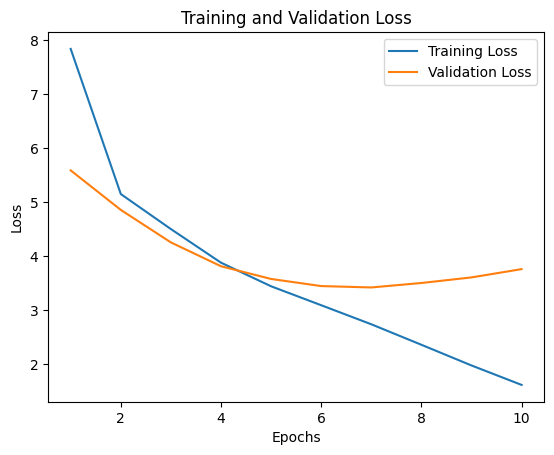

In [172]:
# training / validation loss 시각화
plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), eval_losses, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

## 성능 측정하기
---
챗봇의 경우, 올바른 대답을 하는지가 중요한 평가 지표입니다. 올바른 답변을 하는지 눈으로 확인할 수 있겠지만, 많은 데이터의 경우는 모든 결과를 확인할 수 없을 것입니다. 주어진 질문에 적절한 답변을 하는지 확인하고, BLEU Score를 계산하는 calculate_bleu() 함수도 적용해 보세요.

In [173]:
BOS_ID = 2
EOS_ID = 3

def translate(tokens, model, tokenizer):
    # 입력 문장을 패딩
    padded_tokens = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                                  maxlen=max_len,
                                                                  padding='post')

    ids = []
    output = tf.expand_dims([BOS_ID], 0)  # 시작 토큰 추가

    for i in range(max_len):
        enc_padding_mask, combined_mask, dec_padding_mask = \
            generate_masks(padded_tokens, output)

        predictions, _, _, _ = model(padded_tokens, 
                                     output,
                                     enc_padding_mask,
                                     combined_mask,
                                     dec_padding_mask)

        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if predicted_id == EOS_ID:  # 종료 토큰이면 중단
            return tokenizer.sequences_to_texts([ids])[0]

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    return tokenizer.sequences_to_texts([ids])[0]

In [174]:
def generate_answers(sample_questions, model, tokenizer):
    responses = []
    
    for question in sample_questions:
        # 입력 문장을 정수 인덱스 시퀀스로 변환
        tokens = tokenizer.texts_to_sequences([question])[0]

        # 번역(답변 생성)
        response = translate(tokens, model, tokenizer)

        # 결과 저장
        responses.append(response)
    
    return responses

In [175]:
# 예문
sample_questions = ["지루하다, 놀러가고 싶어.",
                    "간만에 여자친구랑 데이트 하기로 했어.",
                    "집에 있는다는 소리야.",
                    "오늘 일찍 일어났더니 피곤하다."]

answers = generate_answers(sample_questions, transformer, tokenizer)

for question, answer in zip(sample_questions, answers):
    print(f"질문: {question}")
    print(f"답변: {answer}\n")

질문: 지루하다, 놀러가고 싶어.
답변: 자연 스러운 감정 은 네요 .

질문: 간만에 여자친구랑 데이트 하기로 했어.
답변: 데이트 하 면 가능 합니다 .

질문: 집에 있는다는 소리야.
답변: 자연 스러운 감정 은 네요 .

질문: 오늘 일찍 일어났더니 피곤하다.
답변: 당신 은 하나 , 당신 , 당신 , 당신 , 가능 하 도록 말 해 보 세요 .



### BLEU score 

In [176]:
def eval_bleu_single(model, src_sentence, tgt_sentence, tokenizer, max_len):
    src_tokens = tokenizer.texts_to_sequences([src_sentence])[0]
    tgt_tokens = tokenizer.texts_to_sequences([tgt_sentence])[0]

    # 길이가 max_len을 초과하면 평가하지 않음
    if len(src_tokens) > max_len: 
        return None
    if len(tgt_tokens) > max_len: 
        return None
    
    # 모델을 사용하여 번역 생성
    candidate = translate(src_tokens, model, tokenizer)

    # BLEU score 계산
    score = sentence_bleu(tgt_sentence, candidate, smoothing_function=SmoothingFunction().method1)

    return score

In [177]:
score = eval_bleu_single(transformer,
                         "오늘 일찍 일어났더니 피곤하다.",
                         "간만에 여자친구랑 데이트 하기로 했어.",
                         tokenizer,
                         max_len)
print(score)

0.0056414392419841305


In [178]:
def eval_bleu(model, src_sentences, tgt_sentence, tokenizer, verbose=True):
    total_score = 0.0
    sample_size = len(src_sentences)
    
    for idx in range(sample_size):
        score = eval_bleu_single(model, src_sentences[idx], tgt_sentence[idx], tokenizer, verbose)
        if not score: 
            continue
        
        total_score += score
    
    print("Num of Sample:", sample_size)
    print("Total Score:", total_score / sample_size)


In [179]:
eval_bleu(transformer, que_corpus_test, ans_corpus_test, tokenizer, verbose=False)

Num of Sample: 1175
Total Score: 0.0015280364813021134


VOCAB_SIZE = 20000
BATCH_SIZE = 64
D_MODEL = 256

transformer = Transformer(
    n_layers=2,
    d_model=D_MODEL,
    n_heads=8,
    d_ff=1024,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=max_len,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)


optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)
 ===>
beta 설정 삭제

==>
BATCH_SIZE = 256
D_MODEL = 512
==>
n_layers=5,

## 테스트 결과

---

**기준 설정(epoch:10, BATCH_SIZE = 64, D_MODEL = 256, n_layers=2, n_heads=8, d_ff=1024, dropout=0.3)**

![loss](./a_10_l.png)
![answer](./a_10_a.png)

**제시한 답변 처럼 정확히 나오지 않아 epoch을 30을 하여 훈련 실행 후 결과는 평가 손실이 너무 높게 나오며 더 나쁜 결과 나타냄.**

![a_30_l](./a_30_l.png)
![a_30_a](./a_30_a.png)

**기준 설정에서 optimizer의  beta 옵션 삭제, 평가 손실은 기준 설정과 비슷하나 답변은 안 좋음**

![a_30_l](./a_10_Op_l.png)
![a_30_a](./a_10_Op_a.png)


**위 설정에서  BATCH_SIZE = 256, D_MODEL = 512 수정, 평가 손실은 기준 설정과 비슷하나 답변은 기준 설정과 비슷**

![a_10_256_512_l](./a_10_256_512_l.png)
![a_10_256_512_a](./a_10_256_512_a.png)


**위 설정에서  n_layers=5 수정, 평가 손실은 기준 설정과 비슷하나 답변은 기준 설정과 비슷**

![a_10_layer_5_l](./a_10_layer_5_l.png)
![a_10_layer_5_a](./a_10_layer_5_a.png)


## 결론
---
**5 epoch 이상의 진행은 손실 함수 지표상 무의한 것으로 보임.**

**파라미터, 옵티마이저 설정 변경으로는 기준 설정 이상의 결과가 나오지 않음.**

**추후 진행 해 보아야 할 내용**
1. 데이타 증가 부분 로직 재 검토
2. DLthon시 적용한 google translate api를 이용한 데이타 증강
3. wandb를 이용한 옵티마이저 최적화
4. mask에 관련된 심화 학습
   

## 회고

트랜스포머 과제 할 때보다 더 깊이 이해 하게 되었으나, 여전히 데이터 처리 관련하여 더 좋은 방법을 찾아야 할 것 같다.

beam 서치도 어떻게 적용 할 지 한 번 더 고민 해 보아야 하겠다.